Outline:

0. [Imports](#imports)<br>
1. [Loading Data](#loading_data)<br>
2. [Defining Ions](#defining_ions)<br>
3. [Calculating Correlations](#calculating_correlations)<br>
    3.1 [Estimation and Recalculation](#estimate)<br>
    3.2 [Coincidences](#coincidences)<br>
    3.3 [Filtering](#filtering)<br>
    3.4 [Alternative and Custom Representations](#representations)<br>


<!-- 0. Imports
1. Loading Data
2. Defining Ions
3. Calculating Correlations
 -->



<a id='imports'></a>

# 0. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PyCorrCPI as corr

param_dict = {'spinewidth':3,
              'linewidth':2,
              'ticklength':6,
              'tickwidth':3,
              'ticklabelsize':16,
              'axislabelsize':20}


%load_ext autoreload
%autoreload 2

<a id='loading_data'></a>

# 1. Loading data

For this example, we will load in some example simulated data, calculate some covariances and play around a bit with how we can filter and represent the data. I've saved this simualted data (just simulating the Coulomb Explosion of thiophenone into singly charged ions) as a dataframe, which continues the mass, charge, laser shot and 3D momentum for each ion. The package is designed to use momenta (in atomic units) for the covariance calculations.

In [2]:
df_filename = 'thiophenone_simulation.pkl'
simulated_df = pd.read_pickle(df_filename)

In [3]:
simulated_df

,vx,vy,vz,charge,mass,shot,sim_counter,charge_e,mass_amu,px_SI,py_SI,pz_SI,px_AU,py_AU,pz_AU,pmag_AU,KE_eV,shot_ID
0,-5288.235338,2847.554062,-2999.403288,1.600000e-19,5.312000e-26,0.0,1.0,0.998641,31.989615,-2.809111e-22,1.512621e-22,-1.593283e-22,-141.019609,75.934775,-79.984088,179.025346,7.471525,0.0
1,-9010.618960,-11993.327851,5155.002296,1.600000e-19,2.656000e-26,0.0,1.0,0.998641,15.994807,-2.393220e-22,-3.185428e-22,1.369169e-22,-120.141586,-159.911038,68.733364,211.494246,20.854862,0.0
2,-3981.971115,18758.302365,2764.321142,1.600000e-19,1.992000e-26,0.0,1.0,0.998641,11.996105,-7.932086e-23,3.736654e-22,5.506528e-23,-39.819711,187.583024,27.643211,193.745057,23.335129,0.0
3,14205.461049,5272.145031,-1694.116075,1.600000e-19,1.992000e-26,0.0,1.0,0.998641,11.996105,2.829728e-22,1.050211e-22,-3.374679e-23,142.054610,52.721450,-16.941161,152.466608,14.451017,0.0
4,9619.663967,-11453.721084,8544.133444,1.600000e-19,1.992000e-26,0.0,1.0,0.998641,11.996105,1.916237e-22,-2.281581e-22,1.701991e-22,96.196640,-114.537211,85.441334,172.257911,18.446216,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000875,-4972.900197,5454.665443,-13256.633992,1.600000e-19,1.992000e-26,99999.0,100088.0,0.998641,11.996105,-9.906017e-23,1.086569e-22,-2.640721e-22,-49.729002,54.546654,-132.566340,151.730503,14.311816,99999.0
1000876,20879.763436,79961.143160,-36287.459629,1.600000e-19,1.660000e-27,99999.0,100088.0,0.998641,0.999675,3.466041e-23,1.327355e-22,-6.023718e-23,17.399803,66.634286,-30.239550,75.215102,42.202705,99999.0
1000877,80000.265615,-7250.282304,35664.134156,1.600000e-19,1.660000e-27,99999.0,100088.0,0.998641,0.999675,1.328004e-22,-1.203547e-23,5.920246e-23,66.666888,-6.041902,29.720112,73.241133,40.016611,99999.0
1000878,-17811.617513,46874.612675,69441.158760,1.600000e-19,1.660000e-27,99999.0,100088.0,0.998641,0.999675,-2.956729e-23,7.781186e-23,1.152723e-22,-14.843015,39.062177,57.867632,71.378089,38.006688,99999.0


Firstly, we will make a 'Dataset' object from our Pandas dataframe. This class has various functionalities built into it for data analysis, but for this example with simulated data we won't need to use these.

In [4]:
sim_dataset = corr.Dataset(simulated_df)

<a id='defining_ions'></a>

# 2. Defining ions

Next we will identify our ions to use in the covariance calculation, and how we will filter them out from our dataset. Here, we will do this by defining a range of masses for each ion ('mass_amu' column in the dataframe). With experimental data, you would likely do  this on time-of-flight, or a calibrated m/z ratio. For each ion we create an 'Ion' object, which will contain various information that will be used in the covariance calculations. Storing some data associated with each ion in these objects will also prevent some redundant recalculation when calculating multiple covariances.

In [5]:
mrange_list = [(0.99,1.01), (11.99,12.01),(15.99,16.01), (31.95,32.01)]

ion_list = []
label_list = ['H+', 'C+', 'O+', 'S+']
for mrange,label in zip(mrange_list,label_list):
    ion = corr.Ion(label, mrange[0], mrange[1], sim_dataset, filter_param = 'mass_amu', mass=(mrange[0]+mrange[1])/2)
    ion_list.append(ion)

We can check the details of these ion objects we now created.

In [6]:
for number, ion in enumerate(ion_list):
    print(f'Ion number {number}:')
    ion.print_details()

Ion number 0:
'label':H+
'filter_i':0.99
'filter_f':1.01
'filter_param':mass_amu
'shot_array_method':range
'mass':1.0
'center_x':0
'center_y':0
'center_given':False
Ion number 1:
'label':C+
'filter_i':11.99
'filter_f':12.01
'filter_param':mass_amu
'shot_array_method':range
'mass':12.0
'center_x':0
'center_y':0
'center_given':False
Ion number 2:
'label':O+
'filter_i':15.99
'filter_f':16.01
'filter_param':mass_amu
'shot_array_method':range
'mass':16.0
'center_x':0
'center_y':0
'center_given':False
Ion number 3:
'label':S+
'filter_i':31.95
'filter_f':32.01
'filter_param':mass_amu
'shot_array_method':range
'mass':31.979999999999997
'center_x':0
'center_y':0
'center_given':False


<a id='calculating_correlations'></a>

# 3. Calculating Correlations

n-fold covariances/cumulants (and also simple coincidences) are calculated through the 'calc_covariance' function. This function takes in a list of n ions and returns the n-fold cumulant (as well as all the terms in the calculation). As well as your dataset object, and a list of ions, the function requires you to specify the dimensions of the output array and the bin sizes used in calculating this (3D) histogram. There are various `extra' options, including filtering on each coincidence (e.g. by the absolute of the sum of the ions' momenta) and representing the data in different ways. The default representation for each n-fold correlation is some form of Newton plot.

Let's start with a very simple two-fold covariance. We'll use the 'verbose=True' option so that some details about the calculation are printed as its being performed. For now we won't worry much about the inner workings of the calculation though.

In [7]:
### number of bins in the histogram in x,y,z
dim_list = [300, 300, 300]

### the binning for each dimension. for the default Newton plots this is in p in a.u.
### Here we will use 3 a.u. per pixel
bin_list = [3,3,3]


### select the ions for the covariance calculation.
### for the default 2-fold Newton plot, the first ion defines a reference vector
### and the momentum of the second ion is plotted relative to this vector in a plane 
### defined by the two vectors.

covar_ion_list = [ion_list[3], ion_list[2]]

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True, )

Correlating 2 ions
Ions to correlate: S+  ,O+ 
S+ dict not present, generating...
O+ dict not present, generating...
[]
Calculating <AB>
Calculating 1 times
Current time: 2.8 s
Calculating <AB>
Calculating 1 times
Current time: 5.8 s


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Return at 6.8 seconds


The output is saved in the 'output_array' attribute in the covariance object 'covar_test' which was just returned. This will be a 4D array. In the case of this two-fold covariance, the first dimension is of length 3, as it contains the two terms used to calculate the covariance, then the covariance itself. For all cases, the covariance will be stored in the last entry along the first dimension, so we can grab the output as so:

In [8]:
covar_array = covar_test.output_array[-1,:,:,:]

We can plot/analyse this ourselves, or use a function built in to the package. As mentioned above, the covariance itself is a 3D array by default. For this simple Newton plot there is only information in the first two dimensions (x and y). To the plotting function, we then input [2], to denote that we want to sum over the 3rd (z) axis to create a 2D histogram we will plot:

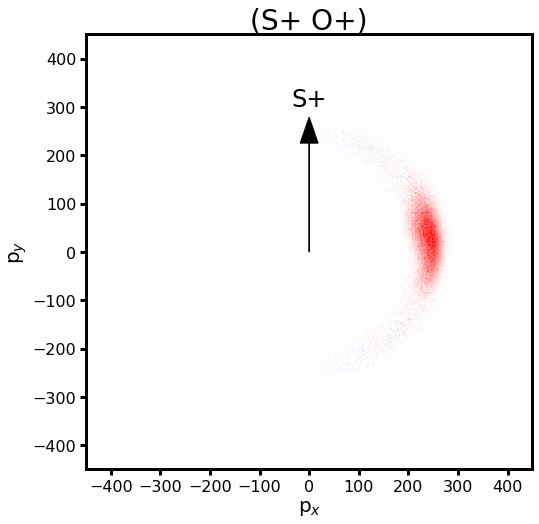

In [9]:
covar_test.plot_2DHist([2], arrow=True)

Calculating a 3- or 4-fold covariance is done in very much the same way, except inputting a longer list of ions. Here we will plot a 3-fold covariance, represented as a Newton plot. The first two ions (S+ and O+) will define the reference vector and plane, and we will plot the third ion (H+) in this frame:

In [10]:
covar_ion_list = [ion_list[3], ion_list[2], ion_list[0]]

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                 )

Correlating 3 ions
Ions to correlate: S+  ,O+  ,H+ 
S+ dict already present
O+ dict already present
H+ dict not present, generating...
[]
Calculating <ABC>
Calculating 1 times
Current time: 0.1 s
Calculating <AB><C>
Calculating 1 times
Current time: 11.7 s
Calculating <AC><B>
Calculating 1 times
Current time: 15.1 s
Calculating <BC><A>
Calculating 1 times
Current time: 18.6 s
Calculating <A><B><C>
Calculating 1 times
Current time: 22.2 s
Return at 25.3 seconds


We can plot this in the same way. This time we will plot three different projections, summing over each axis:

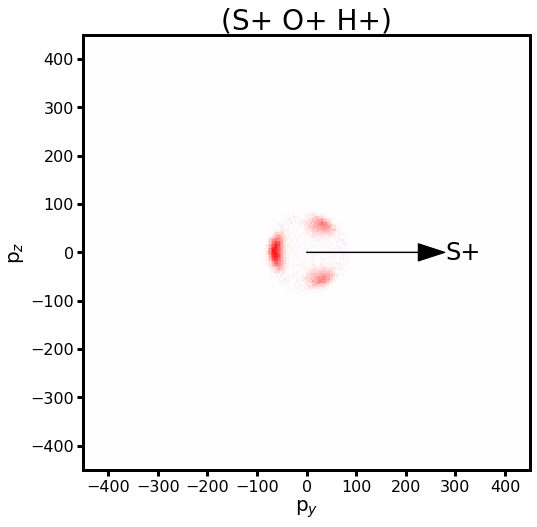

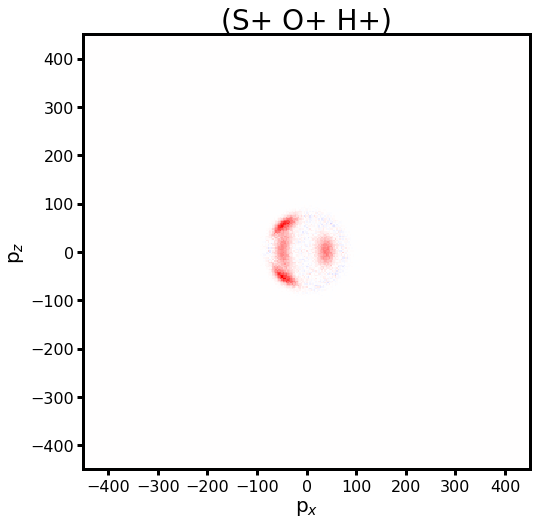

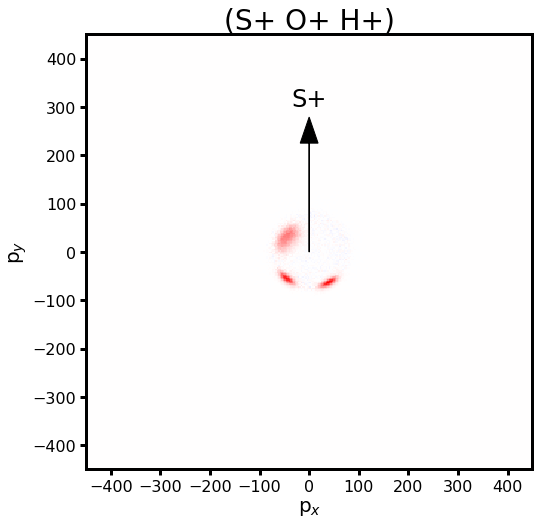

In [11]:
covar_test.plot_2DHist([0,1,2], arrow=True)

Or instead plotting the S+, O+, C+ three-fold covariance

In [15]:
covar_ion_list = [ion_list[3], ion_list[2], ion_list[1]]

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                 )

Correlating 3 ions
Ions to correlate: S+  ,O+  ,C+ 
S+ dict already present
O+ dict already present
C+ dict not present, generating...
[]
Calculating <ABC>
Calculating 1 times
Current time: 0.1 s
Calculating <AB><C>
Calculating 1 times
Current time: 9.3 s
Calculating <AC><B>
Calculating 1 times
Current time: 12.5 s
Calculating <BC><A>
Calculating 1 times
Current time: 15.8 s
Calculating <A><B><C>
Calculating 1 times
Current time: 18.9 s
Return at 21.4 seconds


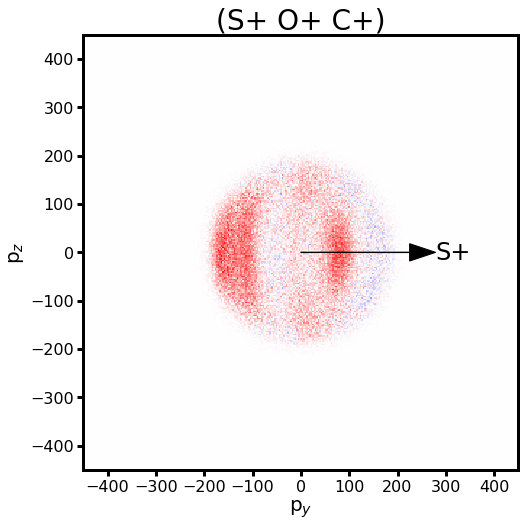

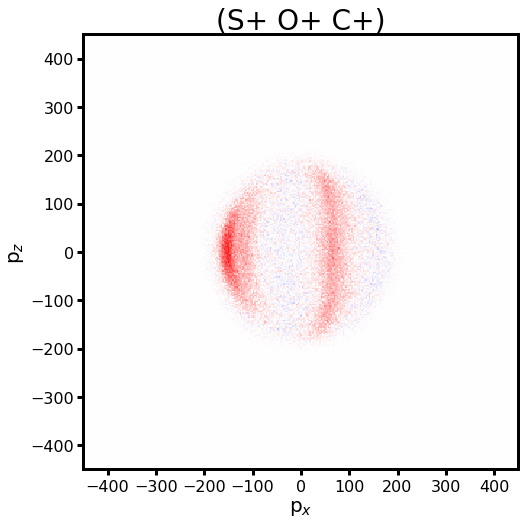

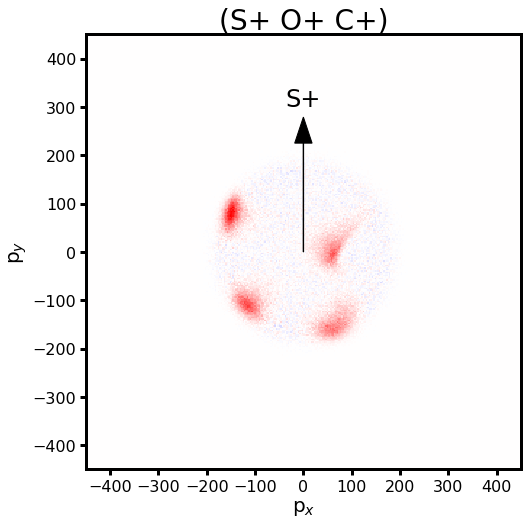

In [16]:
covar_test.plot_2DHist([0,1,2], arrow=True)

Or a four-fold (S+, O+, C+, H+) covariance:

In [17]:
covar_ion_list = [ion_list[3], ion_list[2], ion_list[1], ion_list[0]]

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                 )

Correlating 4 ions
Ions to correlate: S+  ,O+  ,C+  ,H+ 
S+ dict already present
O+ dict already present
C+ dict already present
H+ dict already present
[]
Calculating <ABCD>
Calculating 1 times
Current time: 0.0 s
Calculating <A><BCD>
Calculating 1 times
Current time: 98.3 s
Calculating <B><ACD>
Calculating 1 times
Current time: 129.1 s
Calculating <C><ABD>
Calculating 1 times
Current time: 160.0 s
Calculating <D><ABC>
Calculating 1 times
Current time: 190.6 s
Calculating <AB><CD>
Calculating 1 times
Current time: 220.8 s
Calculating <AC><BD>
Calculating 1 times
Current time: 245.6 s
Calculating <AD><BC>
Calculating 1 times
Current time: 271.7 s
Calculating <AB><C><D>
Calculating 1 times
Current time: 298.6 s
Calculating <AC><B><D>
Calculating 1 times
Current time: 312.5 s
Calculating <AD><B><C>
Calculating 1 times
Current time: 328.1 s
Calculating <BC><A><D>
Calculating 1 times
Current time: 346.6 s
Calculating <BD><A><C>
Calculating 1 times
Current time: 360.5 s
Calculating <CD><A><

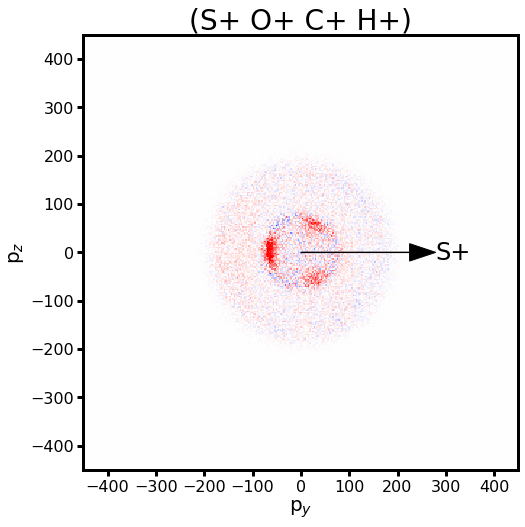

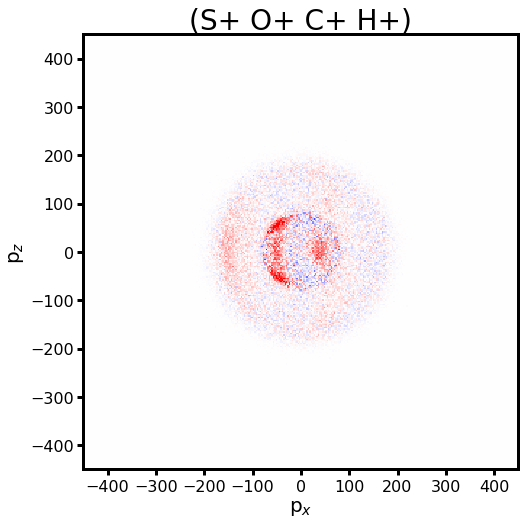

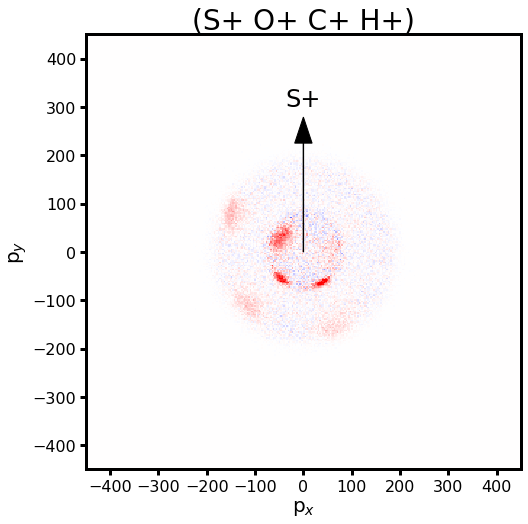

In [20]:
covar_test.plot_2DHist([0,1,2], arrow=True, vfac=1.5)

<a id='estimate'></a>

# 3.1 Estimation and Recalculation



You can see that this fourfold covariance is a decent bit noisier than the three-fold covariances we calculated previously. One thing that can help, at the expense of computation time, is to better estimate the terms in the covariance calcualtion which we do not calculate exactly (which is all of them except the first one, i.e. the true n-fold coincidences). You can read more about the estimation method in this paper: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.109.042802

By default, we estimate these terms exactly one time. We can re-estimate them multiple times and average them to potentially get a 'better' answer. There are different 'types' of terms in the fourfold covariance calculation, and we can specify how many times we calculate each of them. Here is an example with us changing these parameters to hopefully get a nicer-looking covariance, at the cost of computation time:

In [23]:

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                  n_EiEjEkEl=3, n_EijEkl=5, n_EijkEl=5, n_EiEjEkl=5,
                                 )

Correlating 4 ions
Ions to correlate: S+  ,O+  ,C+  ,H+ 
S+ dict already present
O+ dict already present
C+ dict already present
H+ dict already present
[]
Calculating <ABCD>
Calculating 1 times
Current time: 0.0 s
Calculating <A><BCD>
Calculating 5 times
Current time: 95.9 s
Calculating <B><ACD>
Calculating 5 times
Current time: 253.2 s
Calculating <C><ABD>
Calculating 5 times
Current time: 407.2 s
Calculating <D><ABC>
Calculating 5 times
Current time: 561.1 s
Calculating <AB><CD>
Calculating 5 times
Current time: 715.6 s
Calculating <AC><BD>
Calculating 5 times
Current time: 875.5 s
Calculating <AD><BC>
Calculating 5 times
Current time: 997.6 s
Calculating <AB><C><D>
Calculating 5 times
Current time: 1121.6 s
Calculating <AC><B><D>
Calculating 5 times
Current time: 1184.0 s
Calculating <AD><B><C>
Calculating 5 times
Current time: 1247.2 s
Calculating <BC><A><D>
Calculating 5 times
Current time: 1310.6 s
Calculating <BD><A><C>
Calculating 5 times
Current time: 1373.4 s
Calculating <CD

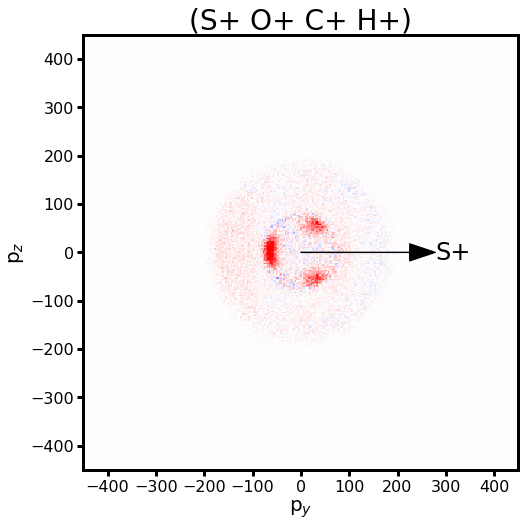

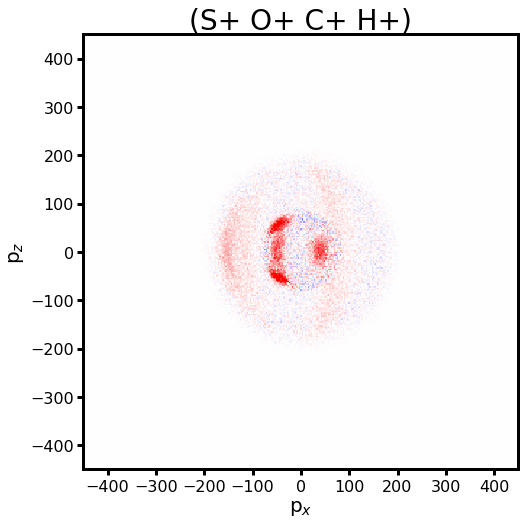

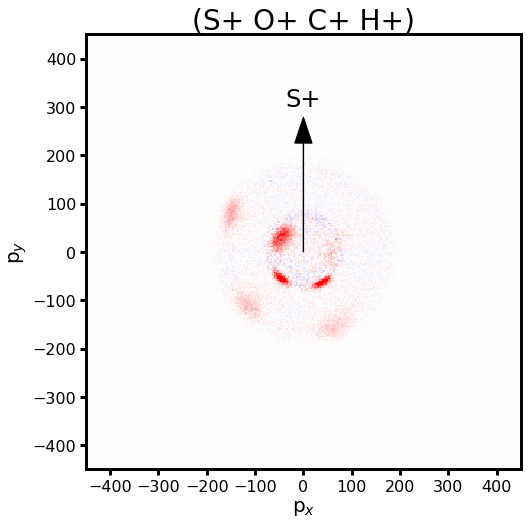

In [24]:
covar_test.plot_2DHist([0,1,2], arrow=True, vfac=1.5)

<a id='coincidences'></a>

# 3.2 Coincidences

In some cases, particularly at low count rates and/or when you can filter to supress the contribution of false coincidences (which we will see how to do in the next section), the full covariance/cumulant analysis may not be needed, and just calculating the n-fold coincidence works well enough (and will calculate much more quickly). We can do this as follows:

In [26]:

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                  only_coincidence=True
                                 )

Correlating 4 ions
Ions to correlate: S+  ,O+  ,C+  ,H+ 
S+ dict already present
O+ dict already present
C+ dict already present
H+ dict already present
[]
Calculating <ABCD>
Calculating 1 times
Current time: 0.0 s
Calculating <A><BCD>
Calculating 0 times
Current time: 91.9 s
Calculating <B><ACD>
Calculating 0 times
Current time: 91.9 s
Calculating <C><ABD>
Calculating 0 times
Current time: 91.9 s
Calculating <D><ABC>
Calculating 0 times
Current time: 91.9 s
Calculating <AB><CD>
Calculating 0 times
Current time: 91.9 s
Calculating <AC><BD>
Calculating 0 times
Current time: 91.9 s
Calculating <AD><BC>
Calculating 0 times
Current time: 91.9 s
Calculating <AB><C><D>
Calculating 0 times
Current time: 91.9 s
Calculating <AC><B><D>
Calculating 0 times
Current time: 91.9 s
Calculating <AD><B><C>
Calculating 0 times
Current time: 91.9 s
Calculating <BC><A><D>
Calculating 0 times
Current time: 91.9 s
Calculating <BD><A><C>
Calculating 0 times
Current time: 91.9 s
Calculating <CD><A><B>
Calculat

In this case, we can see the 'true' correlations, but at the count rate of the simulations, they are fairly contaminated by false coincidences.

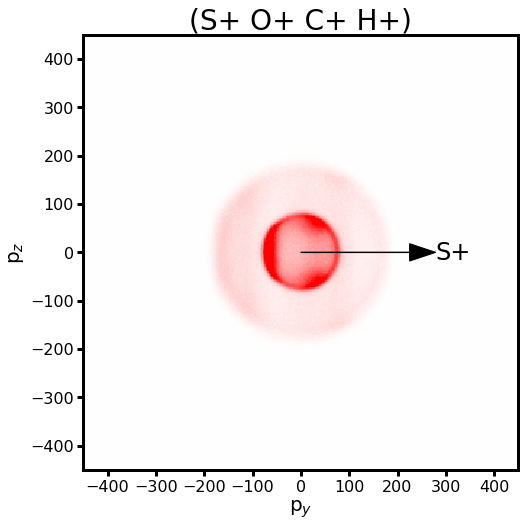

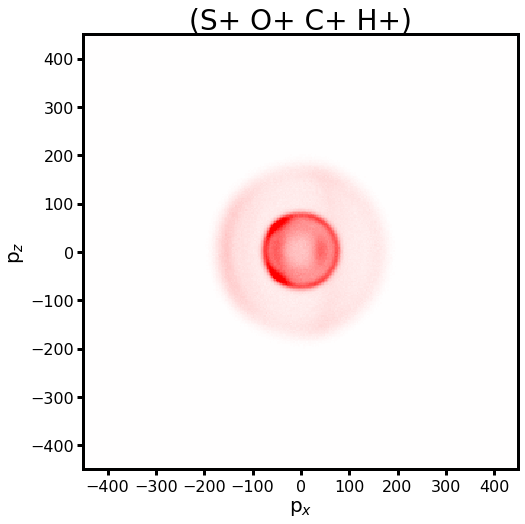

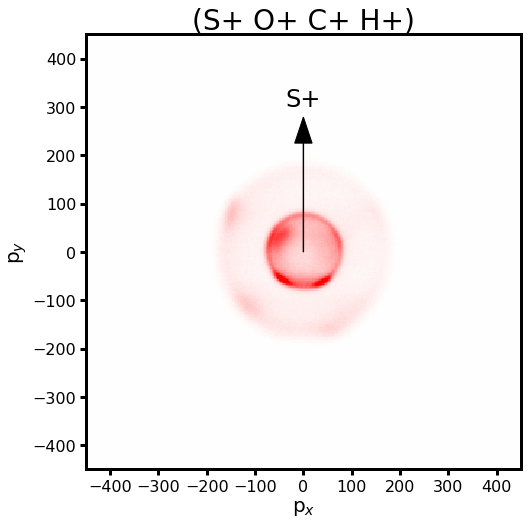

In [27]:
covar_test.plot_2DHist([0,1,2], arrow=True, vfac=1.5)

<a id='filtering'></a>

# 3.3 Filtering

As mentioned above, filtering on a coincidence-by-coincidence basis can help improve the ratio of 'true' coincidences to false ones. The most common thing to filter on would be the absolute magnitude of the sum of the coincident momenta. We can define a 'max' value for this using the 'filter_max' keyword:

In [29]:

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                  only_coincidence=True, filter_max=400
                                 )

Correlating 4 ions
Ions to correlate: S+  ,O+  ,C+  ,H+ 
S+ dict already present
O+ dict already present
C+ dict already present
H+ dict already present
[]
Calculating <ABCD>
Calculating 1 times
Current time: 0.0 s
Calculating <A><BCD>
Calculating 0 times
Current time: 97.0 s
Calculating <B><ACD>
Calculating 0 times
Current time: 97.0 s
Calculating <C><ABD>
Calculating 0 times
Current time: 97.0 s
Calculating <D><ABC>
Calculating 0 times
Current time: 97.0 s
Calculating <AB><CD>
Calculating 0 times
Current time: 97.0 s
Calculating <AC><BD>
Calculating 0 times
Current time: 97.0 s
Calculating <AD><BC>
Calculating 0 times
Current time: 97.0 s
Calculating <AB><C><D>
Calculating 0 times
Current time: 97.0 s
Calculating <AC><B><D>
Calculating 0 times
Current time: 97.0 s
Calculating <AD><B><C>
Calculating 0 times
Current time: 97.0 s
Calculating <BC><A><D>
Calculating 0 times
Current time: 97.0 s
Calculating <BD><A><C>
Calculating 0 times
Current time: 97.0 s
Calculating <CD><A><B>
Calculat

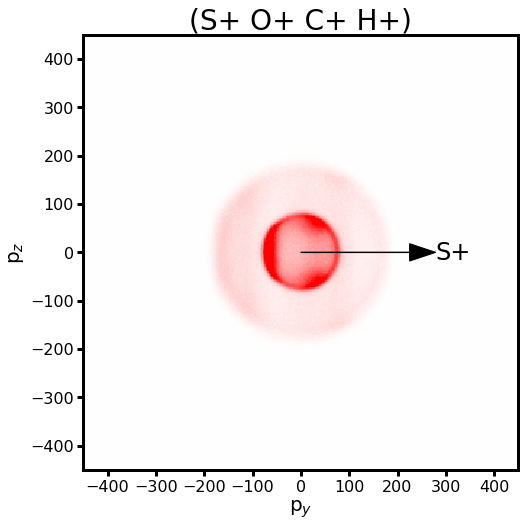

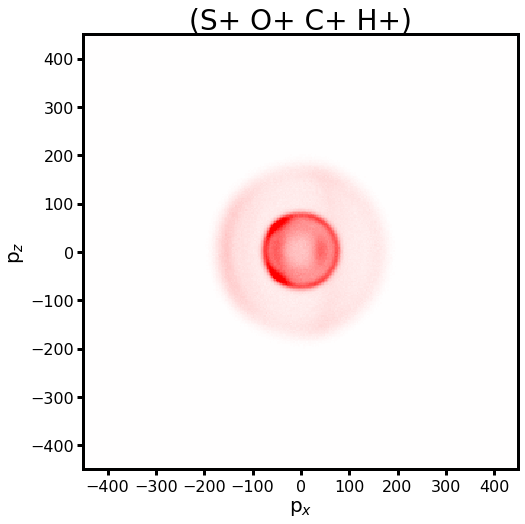

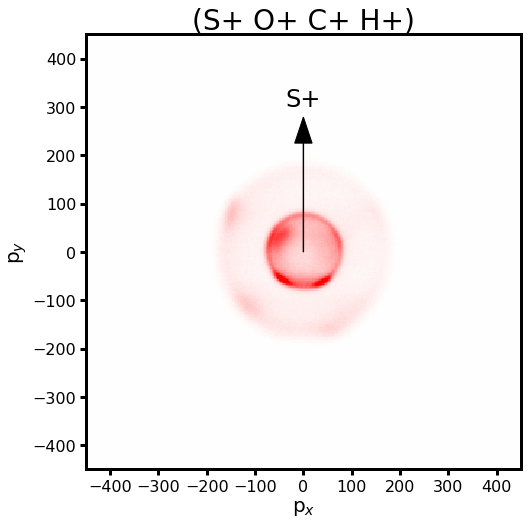

In [30]:
covar_test.plot_2DHist([0,1,2], arrow=True, vfac=1.5)

Filtering on the absolute summed coincident momenta didn't help that much, but other filtering could help, and we can define our own filtering method. We know that for the 'true' coincidences in this channel, the O+ and S+ recoil at close to 90 degrees, so we could instead filter on this angle, only selecting coincidences that are close to this value. To do this, we define a filtering function which takes in a list of the n coincident momentum vectors (and also a list of their magnitudes and masses), and returns a deviation of the S+,O+ angle from 90 degrees. We can then specify a maximum deviation (here done in radians) from 90 degrees that is used in the filtering. We will compile our function with numba (the @njit decorator):

In [12]:
from numba import njit
from PyCorrCPI import *

@njit
def calc_angle_deviation(vec_list,mag_list,mass_list):
    """Calculate the magnitude of the sum of vectors.
    Used for filtering on psum of a coincidence."""
    S_vec = vec_list[0]
    O_vec = vec_list[1]
    S_mag = mag_list[0]
    O_mag = mag_list[1]
    rel_angle_S_O = np.arccos(dot3D(S_vec,O_vec)/(S_mag*O_mag))
    rel_angle_deviation = abs(np.pi/2-rel_angle_S_O)
    return(rel_angle_deviation)

In [47]:

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                  only_coincidence=True, filter_max=0.05, filter_function=calc_angle_deviation
                                 )

Correlating 4 ions
Ions to correlate: S+  ,O+  ,C+  ,H+ 
S+ dict already present
O+ dict already present
C+ dict already present
H+ dict already present
[]
Calculating <ABCD>
Calculating 1 times
Current time: 0.0 s
Calculating <A><BCD>
Calculating 0 times
Current time: 15.9 s
Calculating <B><ACD>
Calculating 0 times
Current time: 15.9 s
Calculating <C><ABD>
Calculating 0 times
Current time: 15.9 s
Calculating <D><ABC>
Calculating 0 times
Current time: 15.9 s
Calculating <AB><CD>
Calculating 0 times
Current time: 15.9 s
Calculating <AC><BD>
Calculating 0 times
Current time: 15.9 s
Calculating <AD><BC>
Calculating 0 times
Current time: 15.9 s
Calculating <AB><C><D>
Calculating 0 times
Current time: 15.9 s
Calculating <AC><B><D>
Calculating 0 times
Current time: 15.9 s
Calculating <AD><B><C>
Calculating 0 times
Current time: 15.9 s
Calculating <BC><A><D>
Calculating 0 times
Current time: 15.9 s
Calculating <BD><A><C>
Calculating 0 times
Current time: 15.9 s
Calculating <CD><A><B>
Calculat

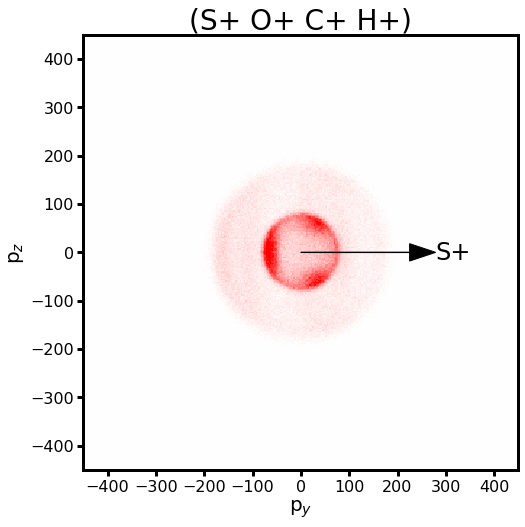

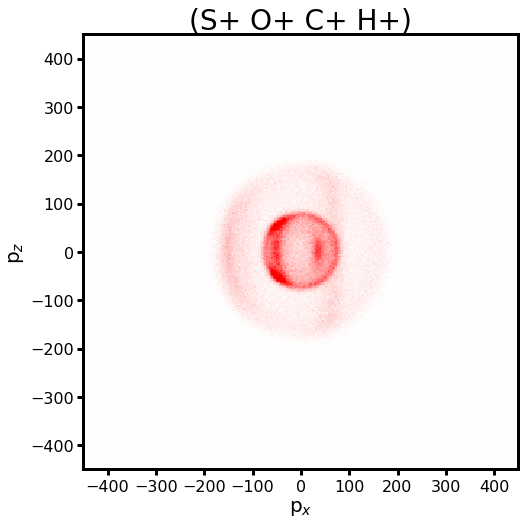

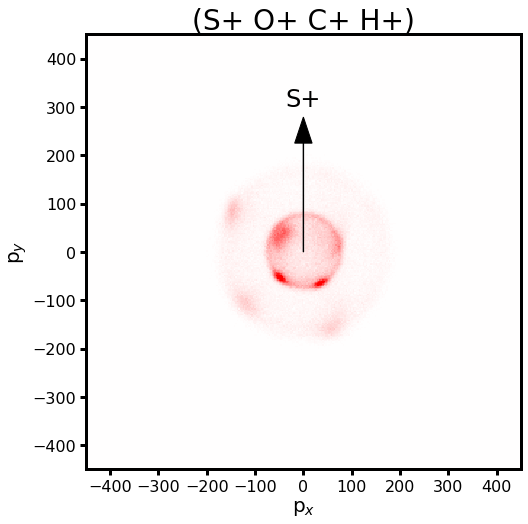

In [49]:
covar_test.plot_2DHist([0,1,2], arrow=True, vfac=1.5)

And we can see that this filtering does help to improve the contribution from false coincidences. This filtering is not just beneficial for the 'pure' coincidence analysis, but can also help in calculating n-fold covariances:

In [55]:

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                  only_coincidence=False, filter_max=0.05, filter_function=calc_angle_deviation,
                                  n_EiEjEkEl=3, n_EijEkl=5, n_EijkEl=5, n_EiEjEkl=5
                                 )

Correlating 4 ions
Ions to correlate: S+  ,O+  ,C+  ,H+ 
S+ dict already present
O+ dict already present
C+ dict already present
H+ dict already present
[]
Calculating <ABCD>
Calculating 1 times
Current time: 0.0 s
Calculating <A><BCD>
Calculating 5 times
Current time: 17.9 s
Calculating <B><ACD>
Calculating 5 times
Current time: 39.8 s
Calculating <C><ABD>
Calculating 5 times
Current time: 62.2 s
Calculating <D><ABC>
Calculating 5 times
Current time: 91.1 s
Calculating <AB><CD>
Calculating 5 times
Current time: 118.7 s
Calculating <AC><BD>
Calculating 5 times
Current time: 141.9 s
Calculating <AD><BC>
Calculating 5 times
Current time: 160.2 s
Calculating <AB><C><D>
Calculating 5 times
Current time: 179.2 s
Calculating <AC><B><D>
Calculating 5 times
Current time: 191.1 s
Calculating <AD><B><C>
Calculating 5 times
Current time: 200.2 s
Calculating <BC><A><D>
Calculating 5 times
Current time: 209.2 s
Calculating <BD><A><C>
Calculating 5 times
Current time: 218.6 s
Calculating <CD><A><B>


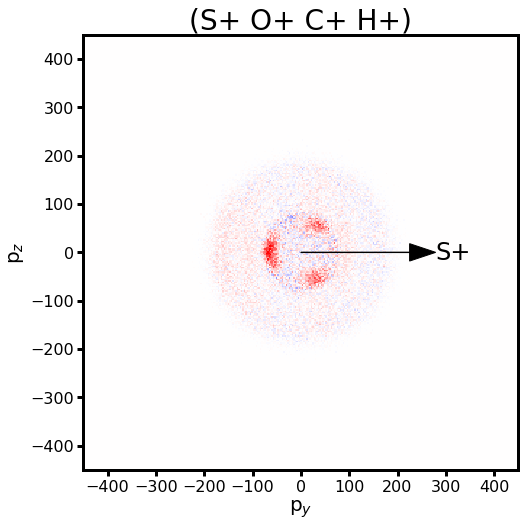

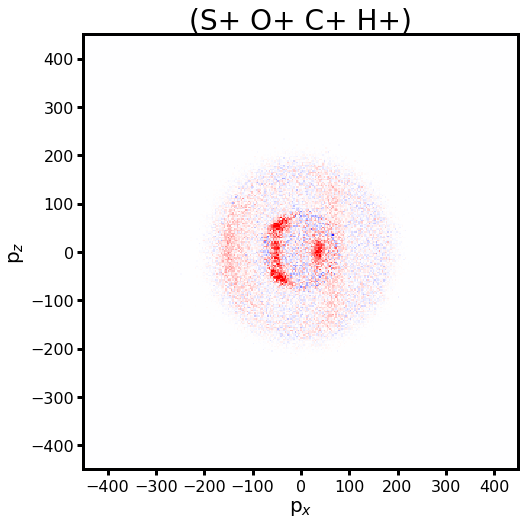

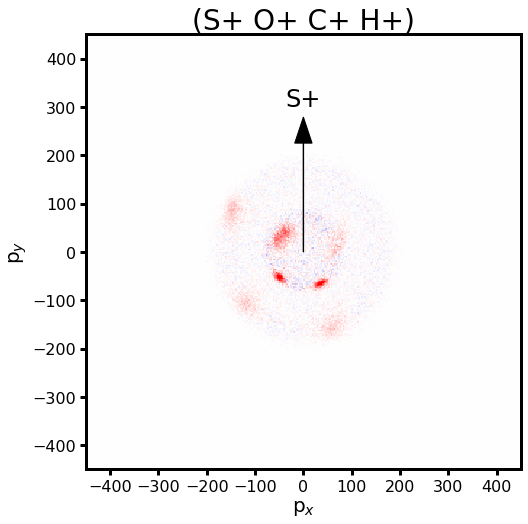

In [56]:
covar_test.plot_2DHist([0,1,2], arrow=True, vfac=1.5)

<a id='representations'></a>

# 3.4 Alternative and Custom Representations

As well as filtering the individual coincidences in various ways, we can also customize how we represent/histogram the correlations. The 'output_functions.py' module in the package contains several example functions for this output formatting. You can either specify one of these inbuilt functions (by entering their name as a string as shown below) or you can build your own, like we did for the filtering. Let's firstly try this built in function, which uses as its three histogram axis: the angle (in degrees) between the first two ions, the sum of the magnitude of all ion's momenta, the total KER:

In [49]:
### number of bins in the histogram in x,y,z
dim_list = [181, 300, 300]

### the binning for each dimension.
bin_list = [1.0,3.0,0.4]

covar_ion_list = [ion_list[3], ion_list[2], ion_list[0]]

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                  custom_function='beta_psum_KER',
                                 )

Correlating 3 ions
Ions to correlate: S+  ,O+  ,H+ 
S+ dict already present
O+ dict already present
H+ dict already present
[]
Calculating <ABC>
Calculating 1 times
Current time: 0.0 s
Calculating <AB><C>
Calculating 1 times
Current time: 4.1 s
Calculating <AC><B>
Calculating 1 times
Current time: 5.1 s
Calculating <BC><A>
Calculating 1 times
Current time: 6.2 s
Calculating <A><B><C>
Calculating 1 times
Current time: 7.2 s
Return at 9.9 seconds


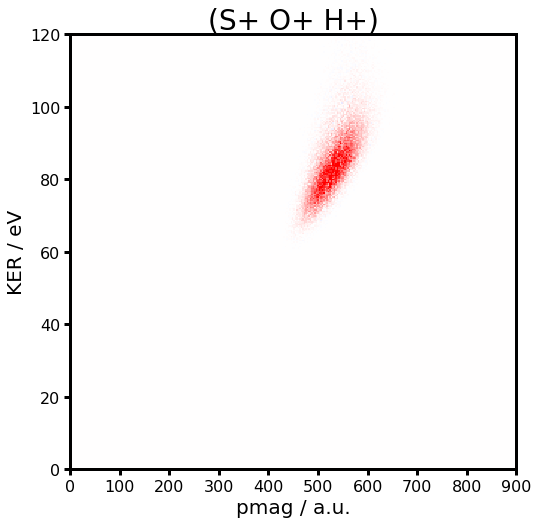

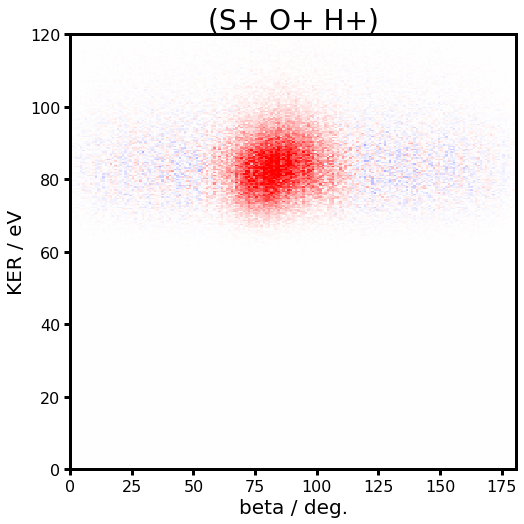

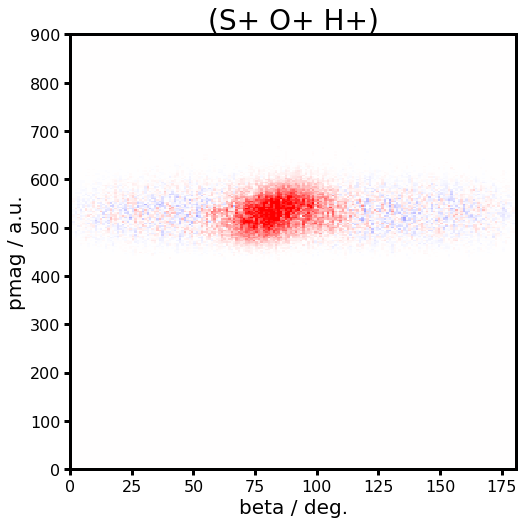

In [47]:
covar_test.plot_2DHist([0,1,2], vfac=1.5, label_list=['beta / deg.', 'pmag / a.u.', 'KER / eV'], 
                       axis_centered_on_zero=False)

Let's define our output function. Let's plot our same Newton plot as we had previously done for 3-fold covariances, but instead of just plotting the third ion, we will plot all ions in the frame. We can do this by making a modified version of the inbuilt Newton plot output functions:

In [13]:
@njit
def output_format_Newton_3fold_allions(vec_list, mag_list, mass_list, bin_list, dim_list):

    z_vec_norm = np.array([0.,0.,1.])
    rot_matrix = np.array([[0.,0.,0.],
      [0.,0.,0.],
      [0.,0.,0.]], dtype='float64')
    
    normal = np.zeros(3, dtype='float64')
    ax_rot = np.zeros(3, dtype='float64')

    A_vec,B_vec,C_vec = vec_list
    A_mag,B_mag,C_mag = mag_list
    x_bin,y_bin,z_bin = bin_list
    x_pixels,y_pixels, z_pixels = dim_list

    A_vec_norm = A_vec/A_mag
    B_vec_norm = B_vec/B_mag
    
    ## find the vector normal to the A,B plane through cross product
    cross3D(B_vec_norm,A_vec_norm,normal)
    normal_vec_norm = normal/norm3D(normal) #this is unecessary as cross product was on normalized vectors(?)

    ## rotate ions into plane
    alpha = np.arccos(normal_vec_norm[2])
    cross3D(normal_vec_norm,z_vec_norm,ax_rot)
    rotation_matrix(ax_rot, -alpha, rot_matrix)

    C_vec_rot = dot3D(C_vec,rot_matrix)
    B_vec_rot = dot3D(B_vec,rot_matrix)
    A_vec_rot = dot3D(A_vec,rot_matrix)

    ## rotate ions in plane to align the A+ vector
    A_vec_norm_rot = dot3D(A_vec_norm,rot_matrix)
    A_vec_norm_rot_norm = A_vec_norm_rot/norm3D(A_vec_norm_rot)

    beta = np.arctan2(A_vec_norm_rot_norm[0],A_vec_norm_rot_norm[1])
    rotation_matrix(z_vec_norm, -beta, rot_matrix)

    C_vec_rot2 = dot3D(C_vec_rot,rot_matrix)
    B_vec_rot2 = dot3D(B_vec_rot,rot_matrix)
    A_vec_rot2 = dot3D(A_vec_rot,rot_matrix)          

    ## bin the C momentum vector in this frame and return
    C_bin_x = int(C_vec_rot2[0]/x_bin+0.5+x_pixels/2)
    C_bin_y = int(C_vec_rot2[1]/y_bin+0.5+y_pixels/2)
    C_bin_z = int(C_vec_rot2[2]/z_bin+0.5+z_pixels/2)

    ## bin the B momentum vector in this frame and return
    B_bin_x = int(B_vec_rot2[0]/x_bin+0.5+x_pixels/2)
    B_bin_y = int(B_vec_rot2[1]/y_bin+0.5+y_pixels/2)
    B_bin_z = int(B_vec_rot2[2]/z_bin+0.5+z_pixels/2)

    ## bin the A momentum vector in this frame and return
    A_bin_x = int(A_vec_rot2[0]/x_bin+0.5+x_pixels/2)
    A_bin_y = int(A_vec_rot2[1]/y_bin+0.5+y_pixels/2)
    A_bin_z = int(A_vec_rot2[2]/z_bin+0.5+z_pixels/2)

    return(([A_bin_x,B_bin_x,C_bin_x],[A_bin_y,B_bin_y,C_bin_y],[A_bin_z,B_bin_z,C_bin_z]))


In [14]:
### number of bins in the histogram in x,y,z
dim_list = [300,300,300]

### the binning for each dimension.
bin_list = [3,3,3]

covar_ion_list = [ion_list[3], ion_list[2], ion_list[0]]

covar_test = corr.calc_covariance(sim_dataset,covar_ion_list,dim_list,bin_list, verbose=True,
                                  custom_function=output_format_Newton_3fold_allions,
                                 )

Correlating 3 ions
Ions to correlate: S+  ,O+  ,H+ 
S+ dict already present
O+ dict already present
H+ dict already present
[]
Calculating <ABC>
Calculating 1 times
Current time: 0.0 s
Calculating <AB><C>
Calculating 1 times
Current time: 10.7 s
Calculating <AC><B>
Calculating 1 times
Current time: 14.2 s
Calculating <BC><A>
Calculating 1 times
Current time: 17.4 s
Calculating <A><B><C>
Calculating 1 times
Current time: 20.8 s
Return at 23.0 seconds


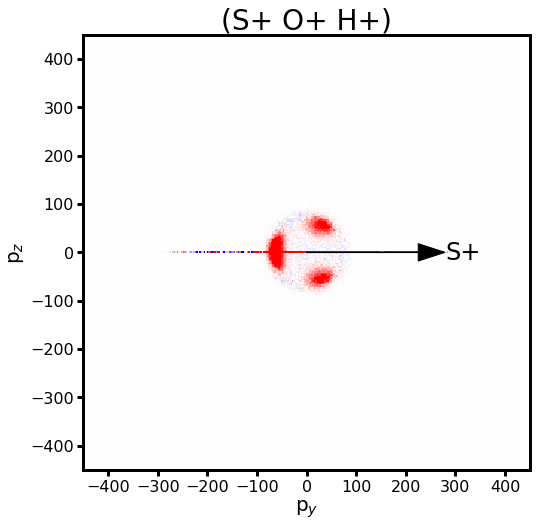

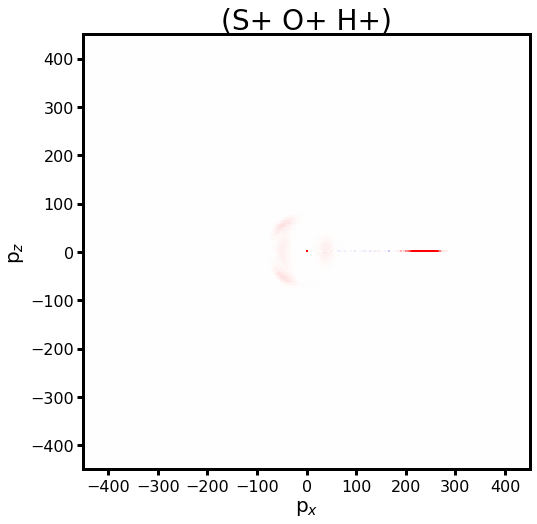

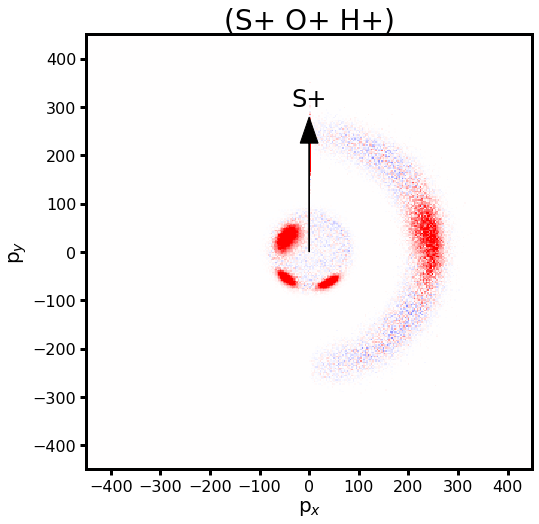

In [15]:
covar_test.plot_2DHist([0,1,2], vfac=40,
                       arrow=True)